In [2]:
# if I want to change between google collab
if True:
    from google.colab import files
    files.upload()    

Saving kevin_token.txt to kevin_token.txt


In [3]:
%%capture
!pip install -U googlemaps
!pip install geojson
!pip install geopandas
!pip install noaa-sdk

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# geo packages
import geojson, googlemaps
import geopandas as gpd

import requests
import json
from datetime import datetime

token = open('kevin_token.txt', "r").read().split('\n')
stations_metadata = pd.read_csv('stations_metadata.csv',encoding = "ISO-8859-1")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: ignored

# streets

In [5]:
if True:
  urls = {'collision':"https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv",
          'streets':'https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.csv',
          'flow_map':'https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.csv',
          'streets_geojson': 'https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.geojson',
          'intersections': 'https://opendata.arcgis.com/datasets/0ea49a3a3ff54ae6af2aaae47dd680fe_5.csv'}
  collision, streets, flow_map, intersections= pd.read_csv(urls['collision'], parse_dates=["INCDTTM"]), gpd.read_file(urls['streets_geojson']), pd.read_csv(urls['flow_map']), pd.read_csv(urls['intersections'])
else:
  collision, streets, flow_map= pd.read_csv('Collisions.csv'), pd.read_csv('Seattle_Streets.csv'), pd.read_csv('Traffic_Flow_Map_Volumes.csv')

Data clean x/y - save till later 

Things needed to figure out to merge 
 - To merge on INTKEY on both collision / streets, but streets is only based on street segments so the intkey is based on on side of the segment. This matters in direction and for duplicate merges 
 - Have to distinguish on JUNCTIONTYPE for intersection related or not as this will imply if the collision happened at the intersection or on the road segment 
 - also implies if we can simply merge on the intkey or need to align the segment of road based off of the LOCATION in collision and seperating out between intsersections and roads
 - Also given that majority of intersections only have two associated roads we can then assume the direction of the collision based on collision notes 
 - 

need the shapefile to pull out the gps 

In [ ]:
# shows the amount of connected roads based on the intersection
streets[['INTKEYLO']].groupby('INTKEYLO').size().reset_index()[[0]].groupby(0).size().reset_index(drop = True)

0    4792
1    8967
2     335
3      14
4       2
dtype: int64

In [6]:
streets.head(3)

,OBJECTID,ARTCLASS,COMPKEY,UNITID,UNITID2,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,STATUS,BLOCKNBR,SPEEDLIMIT,SEGDIR,ONEWAY,ONEWAYDIR,FLOW,SEGLENGTH,SURFACEWIDTH,SURFACETYPE_1,SURFACETYPE_2,INTRLO,DIRLO,INTKEYLO,INTRHI,DIRHI,NATIONHWYSYS,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length,geometry
0,1,2.0,1006,00010,0120,000100120,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,1ST AVE,SENECA ST,UNIVERSITY ST,Minor Arterial,,INSVC,1200.0,25.0,NW,N,,,306.0,48.0,PCC,AC/PCC,1ST AVE AND SENECA ST,NW,29611.0,1ST AVE AND UNIVERSITY ST,SE,N,Downtown Neighborhood,87.0,62.0,1,PRINCIPAL TRANSIT ROUTE,4.0,ART,N,305.966050,"LINESTRING (-122.33754 47.60612, -122.33820 47..."
1,2,2.0,1009,00010,0150,000100150,1ST AVE BETWEEN PIKE ST AND PINE ST,1ST AVE,PIKE ST,PINE ST,Minor Arterial,,INSVC,1500.0,25.0,NW,N,,,426.0,104.0,AC/PCC,PCC,1ST AVE AND PIKE ST,NW,29593.0,1ST AVE AND PINE ST,SE,N,Downtown Neighborhood,57.0,58.0,1,PRINCIPAL TRANSIT ROUTE,5.0,ART,N,426.031562,"LINESTRING (-122.34001 47.60882, -122.34092 47..."
2,3,0.0,1032,00015,0080,000150080,1ST AVE N BETWEEN VALLEY UPPER ST AND ALOHA ST,1ST AVE N,VALLEY UPPER ST,ALOHA ST,Not Designated,,INSVC,800.0,20.0,N,N,,,297.0,0.0,PCC,None,1ST AVE N AND VALLEY UPPER ST,N,28897.0,1ST AVE N AND ALOHA ST,S,N,Neighborhood Yield Street,0.0,0.0,0,NOT DESIGNATED,17.0,NON-ART,N,297.147592,"LINESTRING (-122.35538 47.62637, -122.35538 47..."


In [7]:
collision.head(3)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.391897,47.679463,1,1226,1226,3612934,Matched,Intersection,24013.0,EARL AVE NW AND NW 70TH ST,,NaN,1,Property Damage Only Collision,Angles,3,0,0,2,0,0,0,2013/03/30 00:00:00+00,2013-03-30 10:30:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.312048,47.620501,2,49500,49500,2622152,Unmatched,Block,NaN,E THOMAS ST BETWEEN 15TH S AVE E AND 16TH AVE E,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2006/09/01 00:00:00+00,2006-09-01 00:00:00,Mid-Block (not related to intersection),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,6244041.0,NaN,NaN,NaN,0,0,N
2,-122.330559,47.616840,3,46400,46400,1783671,Matched,Intersection,29850.0,HOWELL ST AND MINOR AVE,NaN,NaN,2b,Serious Injury Collision,Left Turn,2,0,0,2,1,1,0,2005/03/10 00:00:00+00,2005-03-10 17:38:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,NaN,5069036.0,NaN,28,From opposite direction - one left turn - one ...,0,0,N


# Data Clean missing x/Y

In [60]:
# NAs of location 
print('{} without locations '.format(len(collision[collision.LOCATION.isna()])))
print('{} without locations/x/y'.format(len(collision[(collision.LOCATION.isna()) & (collision.X.isna())])))
print('{} without x/y but with location'.format(len(collision[(collision.LOCATION.notna()) & (collision.X.isna())])))
print('{} without x/y with intkey '.format(len(collision[(collision.INTKEY.notna()) & collision.X.isna()])))

4579 without locations 
4579 without locations/x/y
2885 without x/y but with location
350 without x/y with intkey 


In [61]:
data_clean = collision[(collision.LOCATION.notna()) & (collision.X.isna())].reset_index(drop = True)
data_clean.head(3)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,NaN,NaN,11,53800,53800,2609018,Matched,Block,NaN,BROAD ST BETWEEN HARRISON ST AND BROAD ST EB O...,NaN,NaN,2,Injury Collision,Left Turn,2,0,0,2,2,0,0,2006/10/04 00:00:00+00,2006-10-04 00:00:00,Mid-Block (but intersection related),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Clear,Dry,Daylight,NaN,6277029.0,NaN,15,From same direction - one left turn - one stra...,0,0,N
1,NaN,NaN,28,39600,39600,C646585,Matched,Block,NaN,SENECA ST OFF RP BETWEEN ALASKAN WY VI NB AND ...,NaN,NaN,2,Injury Collision,Right Turn,2,0,0,2,1,0,0,2005/03/28 00:00:00+00,2005-03-28 06:55:00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Wet,Dawn,NaN,5087062.0,NaN,16,From same direction - one right turn - one str...,0,0,N
2,NaN,NaN,55,88700,88700,3312640,Matched,Block,NaN,COLUMBIA ST ON RP BETWEEN 1ST AVE AND ALASKAN ...,NaN,NaN,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2008/10/07 00:00:00+00,2008-10-07 00:00:00,Mid-Block (but intersection related),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,1,Clear,Dry,Dark - Street Lights On,NaN,8281037.0,NaN,50,Fixed object,0,0,N


In [ ]:
data_clean[['JUNCTIONTYPE']].groupby('JUNCTIONTYPE').size().reset_index()

,JUNCTIONTYPE,0
0,At Intersection (but not related to intersection),27
1,At Intersection (intersection related),319
2,Driveway Junction,35
3,Mid-Block (but intersection related),340
4,Mid-Block (not related to intersection),2093
5,Ramp Junction,23


In [ ]:
#data_clean[data_clean['JUNCTIONTYPE'] == 'Mid-Block (not related to intersection)'].reset_index()['LOCATION'][0]
#test = data_clean[~data_clean['LOCATION'].str.contains('ALASKAN WY VI') & ~data_clean['LOCATION'].str.contains('ALASKAN WAY')].reset_index()

1. simple google search of intersection 
2. between on simple search 
3.

In [126]:
googlefilter = data_clean[(~data_clean['LOCATION'].str.contains('ALASKAN WY') )& (~data_clean['LOCATION'].str.contains('ALASKAN WAY')) & (~data_clean['LOCATION'].str.contains('BETWEEN'))].reset_index()

In [127]:
googlefilter.head(3)

,index,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,14,NaN,NaN,577,19700,19700,1772779,Matched,Intersection,31489.0,RAINIER AVE S AND S STEVENS ST,NaN,NaN,2,Injury Collision,Angles,3,0,0,2,1,0,0,2004/05/08 00:00:00+00,2004-05-08 00:00:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Overcast,Dry,Daylight,NaN,4129015.0,NaN,10,Entering at angle,0,0,N
1,20,NaN,NaN,1047,33200,33200,1795420,Matched,Intersection,32163.0,DUWAMISH AVE S AND S SPOKANE SR ST,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2005/05/20 00:00:00+00,2005-05-20 12:43:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Y,0,Raining,Wet,Daylight,NaN,5140029.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,30,NaN,NaN,2659,264100,264880,E743191,Matched,Intersection,30534.0,4TH AVE S AND XW WELLER,,NaN,2,Injury Collision,Left Turn,5,0,0,2,1,0,0,2017/10/22 00:00:00+00,2017-10-22 09:22:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N


In [163]:
gmaps = googlemaps.Client(key=token[0])
googlefilter['Google_address'] = None
for i in range(len(googlefilter)):
  temp_geocode = gmaps.geocode('{}, Seattle, WA'.format(googlefilter.LOCATION[i]))
  if temp_geocode[0]['types'][0] == 'intersection':
    geocode = temp_geocode[0]['geometry']['location']
    googlefilter.X[i], googlefilter.Y[i] = geocode['lng'], geocode['lat']
    googlefilter['Google_address'][i] = temp_geocode[0]['address_components'][0]['short_name']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [186]:
google_merge = googlefilter.merge(intersections, how = 'left', left_on = 'INTKEY', right_on = 'COMPKEY')
alaskan_address = data_clean[(data_clean['LOCATION'].str.contains('ALASKAN'))].reset_index().merge(intersections, how = 'left', left_on = 'INTKEY', right_on = 'COMPKEY')
google_merge = google_merge.append(alaskan_address[alaskan_address['COMPKEY'].notna()])
google_merge['X_x'] = google_merge.apply(lambda x: x['X_y'] if str(x['X_x']) == 'nan' else x['X_x']  ,axis = 1 )
google_merge['Y_x'] = google_merge.apply(lambda x: x['Y_y'] if str(x['Y_x']) == 'nan' else x['Y_x']  ,axis = 1 )
google_merge = google_merge.reset_index(drop = True)


for  i in range(len(google_merge)):
  temp = google_merge.iloc[i]
  collision['X'][temp['index']] = google_merge['X_x'][i]
  collision['Y'][temp['index']] = google_merge['Y_x'][i]

In [190]:
# connecting the intersetion key with that of streets only for colisions 
columns = list(streets.columns)
columns.remove('INTKEYLO')
colision_con = streets[streets['INTKEYLO'].notna()].groupby('INTKEYLO')[columns].apply(lambda g: g.reset_index(drop = True).to_dict()).reset_index()
collision_street = collision.merge(colision_con, how = 'left', left_on = 'INTKEY', right_on='INTKEYLO')
#len(collision_street[collision_street['INTKEYLO'].notna()]) / len(collision_street[collision_street['INTKEY'].notna()])
#len(collsision_street[collision_street['INTKEYLO'].notna()]) / len(collision_street)  # 50% aren't on an intersection 

In [192]:
collision_street.to_csv('collision_data_eng.csv')

# weather

In [ ]:
wa_stations = stations_metadata[stations_metadata['stationid'].str.contains('US1WAKG')].reset_index()

In [ ]:

r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/datatypes?datasetid=GHCND&limit=200', headers={'token':token[1]})
d= json.loads(r.text)

In [ ]:
d
#GHCND ,  NEXRAD2 , NEXRAD3
#AWND, EVAP, MDSF, PRCP, SNOW, SNWD, WSFG, TMAX, TAVG, TMIN

In [ ]:
BBox = (collision.X.min(),   collision.Y.min(),collision.X.max(), collision.Y.max())
seattle_stations = wa_stations[(wa_stations['lat ']> collision.Y.min()) &(wa_stations['lat ']< collision.Y.max()) & (wa_stations['long']> collision.X.min()) &(wa_stations['long']< collision.X.max())].reset_index(drop = True)

In [ ]:
  #make the api call
  year = '2015'
  r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=AWND&EVAP&MDSF&PRCP&SNOW&SNWD&WSFG&TMAX&TAVG&TMIN&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':token[1]})
  #load the api response as a json
  d = json.loads(r.text)
  d

In [ ]:
#Long Beach Airport station
station_id = 'GHCND:USW00024281'

dates_temp = []
dates_prcp = []
temps = []
prcp = []

#for each year from 2015-2019 ...
for year in range(2017, 2018):
    year = str(year)
    print('working on year '+year)
    
    #make the api call
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:US1WAKG0225&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':token[1]})
    d = json.loads(r.text)

working on year 2017


In [ ]:
temp_df = pd.DataFrame.from_dict(d['results'])
temp_df.pivot_table('value', ['date','station'], 'datatype').reset_index()

datatype,date,station,DAPR,MDPR,PRCP
0,2017-09-25T00:00:00,GHCND:US1WAKG0225,NaN,NaN,3.0
1,2017-09-26T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0
2,2017-09-27T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0
3,2017-09-28T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0
4,2017-09-29T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0
5,2017-09-30T00:00:00,GHCND:US1WAKG0225,NaN,NaN,5.0
6,2017-10-02T00:00:00,GHCND:US1WAKG0225,2.0,5.0,NaN
7,2017-10-03T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0
8,2017-10-04T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0
9,2017-10-05T00:00:00,GHCND:US1WAKG0225,NaN,NaN,0.0


In [ ]:
temp_df

,date,datatype,station,attributes,value
0,2017-09-25T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",3
1,2017-09-26T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",0
2,2017-09-27T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",0
3,2017-09-28T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",0
4,2017-09-29T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",0
5,2017-09-30T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",5
6,2017-10-02T00:00:00,DAPR,GHCND:US1WAKG0225,",,N,",2
7,2017-10-02T00:00:00,MDPR,GHCND:US1WAKG0225,",,N,",5
8,2017-10-03T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",0
9,2017-10-04T00:00:00,PRCP,GHCND:US1WAKG0225,",,N,",0


In [ ]:
#Long Beach Airport station
station_id = 'GHCND:USW00024281'

dates_temp = []
dates_prcp = []
temps = []
prcp = []
weather_metrics = ['AWND', 'EVAP', 'MDSF', 'PRCP', 'SNOW', 'SNWD', 'WSFG', 'TMAX', 'TAVG', 'TMIN']
df = pd.DataFrame(columns=weather_metrics)
#for each year from 2015-2019 ...
for year in range(2018, 2019):
    year = str(year)
    print('working on year '+year)
    for i in range(len(seattle_stations)):
      #make the api call
      print(seattle_stations['stationid'][i])
      r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:{}&startdate={}-01-01&enddate={}-12-31'.format(seattle_stations['stationid'][i],year,year), headers={'token':token[1]})
      #load the api response as a json
      d = json.loads(r.text)
      if d != {}:
        temp_df = pd.DataFrame.from_dict(d['results'])
        station_df = temp_df.pivot_table('value', ['date','station'], 'datatype').reset_index()
        print('sucess')



working on year 2018
US1WAKG0005
sucess
US1WAKG0006
US1WAKG0020
US1WAKG0033
sucess
US1WAKG0038
US1WAKG0040
US1WAKG0052
US1WAKG0064
US1WAKG0072
sucess
US1WAKG0074
US1WAKG0079
sucess
US1WAKG0082
US1WAKG0083
US1WAKG0089
US1WAKG0104
US1WAKG0106
US1WAKG0108
US1WAKG0136
sucess
US1WAKG0142
US1WAKG0145
sucess
US1WAKG0162
US1WAKG0165
US1WAKG0168
US1WAKG0171
US1WAKG0179
US1WAKG0180
US1WAKG0188
US1WAKG0190
sucess
US1WAKG0192
sucess
US1WAKG0199
sucess
US1WAKG0200
sucess
US1WAKG0204
US1WAKG0208
US1WAKG0225
sucess
US1WAKG0229
sucess
US1WAKG0234
sucess
US1WAKG0238
sucess
US1WAKG0239
sucess
US1WAKG0241
sucess
US1WAKG0243
sucess


In [ ]:
requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:{}&startdate={}-01-01&enddate={}-12-31'.format('US1WAKG0225',2018,2018), headers={'token':token[1]}).text

'{"metadata":{"resultset":{"offset":1,"count":295,"limit":25}},"results":[{"date":"2018-01-01T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":0},{"date":"2018-01-02T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":0},{"date":"2018-01-03T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":"T,,N,","value":0},{"date":"2018-01-04T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":0},{"date":"2018-01-05T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":64},{"date":"2018-01-06T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":145},{"date":"2018-01-07T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":58},{"date":"2018-01-08T00:00:00","datatype":"PRCP","station":"GHCND:US1WAKG0225","attributes":",,N,","value":104},{"date":"2018-03-12T00:00:00","datatype":"PRCP"

In [ ]:
df_temp = pd.DataFrame()

#populate date and average temperature fields (cast string date to datetime and convert temperature from tenths of Celsius to Fahrenheit)
df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp]
df_temp['avgTemp'] = [float(v)/10.0*1.8 + 32 for v in temps]

<Response [200]>

In [ ]:
n = noaa.NOAA()
res = n.get_forecasts('98101', 'US', True)
for i in res:
    print(i)

# end

In [ ]:
intersections_filter = data_clean[data_clean.JUNCTIONTYPE.notna()]
intersections_filter = intersections_filter[(intersections_filter.JUNCTIONTYPE.str.contains('intersection related')) & (intersections_filter.JUNCTIONTYPE.str.contains('At Intersection'))].reset_index(drop = True)

In [ ]:
intersections_filter = data_clean[data_clean.JUNCTIONTYPE.notna()]
intersections_filter[intersections_filter]

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,NaN,NaN,35,33200,33200,1795420,Matched,Intersection,32163.0,DUWAMISH AVE S AND S SPOKANE SR ST,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2005/05/20 00:00:00+00,2005-05-20 12:43:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Y,0,Raining,Wet,Daylight,NaN,5140029.0,NaN,11,From same direction - both going straight - bo...,0,0,N
1,NaN,NaN,356,19800,19800,1060128,Matched,Block,NaN,ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ...,NaN,NaN,1,Property Damage Only Collision,Other,1,0,0,1,0,0,0,2004/12/23 00:00:00+00,2004-12-23 00:20:00,Mid-Block (not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,1,Clear,Dry,Dark - Street Lights On,NaN,4358043.0,NaN,50,Fixed object,0,0,N
2,NaN,NaN,590,36900,36900,1933306,Matched,Block,NaN,BROAD ST BETWEEN 5TH AVE N AND TAYLOR AVE N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2005/10/04 00:00:00+00,2005-10-04 00:00:00,Mid-Block (but intersection related),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Clear,Dry,Daylight,NaN,5277028.0,NaN,11,From same direction - both going straight - bo...,0,0,N
3,NaN,NaN,615,19700,19700,1772779,Matched,Intersection,31489.0,RAINIER AVE S AND S STEVENS ST,NaN,NaN,2,Injury Collision,Angles,3,0,0,2,1,0,0,2004/05/08 00:00:00+00,2004-05-08 00:00:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Overcast,Dry,Daylight,NaN,4129015.0,NaN,10,Entering at angle,0,0,N
4,NaN,NaN,829,23000,23000,537838,Matched,Block,NaN,BATTERY ST TUN ON RP BETWEEN BELL ST AND ALASK...,NaN,NaN,1,Property Damage Only Collision,Rear Ended,0,0,0,2,0,0,0,2004/01/16 00:00:00+00,2004-01-16 08:25:00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4016025.0,NaN,14,From same direction - both going straight - on...,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,NaN,NaN,219128,330894,332394,EA30284,Matched,Intersection,30392.0,ALASKAN WAY S AND S DEARBORN ST,,NaN,2,Injury Collision,Other,1,0,0,1,1,0,0,2020/04/20 00:00:00+00,2020-04-20 22:03:00,At Intersection (intersection related),26.0,MOTOR VEHICLE STRUCK OBJECT IN ROAD,NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,50,Fixed object,0,0,N
2881,NaN,NaN,219213,331841,333341,EA34143,Matched,Intersection,34103.0,HOLDEN ST ON RP AND SR509 NB,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/05/11 00:00:00+00,2020-05-11 05:48:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
2882,NaN,NaN,219356,329242,330742,3837937,Matched,Block,NaN,RAINIER AVE S BETWEEN CORNELL AVE S AND 75TH A...,,NaN,2,Injury Collision,Rear Ended,2,0,0,2,1,0,0,2020/02/24 00:00:00+00,2020-02-24 06:43:00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Clear,Dry,Dawn,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N
2883,NaN,NaN,219764,331368,332868,EA33723,Matched,Intersection,30534.0,4TH AVE S AND XW WELLER,,NaN,2,Injury Collision,Rear Ended,3,0,0,2,1,0,0,2020/05/02 00:00:00+00,2020-05-02 12:11:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Raining,Wet,Daylight,NaN,NaN,NaN,14,From same direction - both going strai

In [ ]:
intersections_filter['year'] = intercetions['INCDATE'].apply(lambda x : x.split('/')[0] )
intersections_filter.groupby('year').size()

year
2004    22
2005    10
2013     2
2017     1
dtype: int64

In [ ]:
#intersections[intersections['UNITDESC'].str.contains('RAINIER AVE S AND S STEVENS ST')]
test.head(2)

,OBJECTID,ARTCLASS,COMPKEY,UNITID,UNITID2,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,STATUS,BLOCKNBR,SPEEDLIMIT,SEGDIR,ONEWAY,ONEWAYDIR,FLOW,SEGLENGTH,SURFACEWIDTH,SURFACETYPE_1,SURFACETYPE_2,INTRLO,DIRLO,INTKEYLO,INTRHI,DIRHI,NATIONHWYSYS,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length,geometry,INTLO_GPS
0,1,2.0,1006,00010,0120,000100120,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,1ST AVE,SENECA ST,UNIVERSITY ST,Minor Arterial,,INSVC,1200.0,25.0,NW,N,,,306.0,48.0,PCC,AC/PCC,1ST AVE AND SENECA ST,NW,29611.0,1ST AVE AND UNIVERSITY ST,SE,N,Downtown Neighborhood,87.0,62.0,1,PRINCIPAL TRANSIT ROUTE,4.0,ART,N,305.966050,"LINESTRING (-122.33754 47.60612, -122.33820 47...","(-122.33754426965875, 47.60612175846337)"
1,2,2.0,1009,00010,0150,000100150,1ST AVE BETWEEN PIKE ST AND PINE ST,1ST AVE,PIKE ST,PINE ST,Minor Arterial,,INSVC,1500.0,25.0,NW,N,,,426.0,104.0,AC/PCC,PCC,1ST AVE AND PIKE ST,NW,29593.0,1ST AVE AND PINE ST,SE,N,Downtown Neighborhood,57.0,58.0,1,PRINCIPAL TRANSIT ROUTE,5.0,ART,N,426.031562,"LINESTRING (-122.34001 47.60882, -122.34092 47...","(-122.34001342746024, 47.60882096003467)"


In [ ]:
test = streets[streets['INTRHI'].notna()]
test[test['INTRHI'].str.contains('RAINIER AVE S')]

,OBJECTID,ARTCLASS,COMPKEY,UNITID,UNITID2,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,STATUS,BLOCKNBR,SPEEDLIMIT,SEGDIR,ONEWAY,ONEWAYDIR,FLOW,SEGLENGTH,SURFACEWIDTH,SURFACETYPE_1,SURFACETYPE_2,INTRLO,DIRLO,INTKEYLO,INTRHI,DIRHI,NATIONHWYSYS,STREETTYPE,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length,geometry,INTLO_GPS
909,910,1.0,12348,09345,0110,093450110,RAINIER AVE S BETWEEN S NORMAN ST AND I90 WB R...,RAINIER AVE S,S NORMAN ST,I90 WB RAINIER NB OF RP,Principal Arterial,,INSVC,1100.0,25.0,SE,N,,,350.0,65.0,AC/PCC,None,RAINIER AVE S AND S NORMAN ST,SE,30798.0,I90 WB RAINIER NB OF RP AND RAINIER AVE S,NW,Y,Urban Village Main,47.0,0.0,1,PRINCIPAL TRANSIT ROUTE,1.0,ART,N,349.710433,"LINESTRING (-122.30972 47.59351, -122.30942 47...","(-122.30971805623318, 47.593505775152046)"
910,911,1.0,12350,09345,0130,093450130,RAINIER AVE S BETWEEN MTS N RAINIER CONNCT TRL...,RAINIER AVE S,MTS N RAINIER CONNCT TRL,I90 EB OFF RP,Principal Arterial,,INSVC,1300.0,25.0,SE,N,,,468.0,65.0,AC/PCC,None,MTS N RAINIER CONNCT TRL AND RAINIER AVE S,SE,519887.0,I90 EB OFF RP AND RAINIER AVE S,NW,Y,Urban Center Connector,47.0,0.0,1,PRINCIPAL TRANSIT ROUTE,1.0,ART,N,468.559435,"LINESTRING (-122.30765 47.59080, -122.30747 47...","(-122.30765111723376, 47.59080016226259)"
911,912,1.0,12363,09345,0240,093450240,RAINIER AVE S BETWEEN 25TH AVE S AND S BAYVIEW ST,RAINIER AVE S,25TH AVE S,S BAYVIEW ST,Principal Arterial,,INSVC,2400.0,25.0,SE,N,,,102.0,52.0,AC/PCC,None,25TH AVE S AND RAINIER AVE S,SE,31466.0,RAINIER AVE S AND S BAYVIEW ST,NW,Y,Urban Village Main,44.0,0.0,1,PRINCIPAL TRANSIT ROUTE,0.0,ART,N,101.769254,"LINESTRING (-122.30036 47.58124, -122.30017 47...","(-122.30035615922489, 47.58124227930574)"
912,913,1.0,12375,09345,0352,093450352,RAINIER AVE S BETWEEN S COURT ST AND 33RD AVE S,RAINIER AVE S,S COURT ST,33RD AVE S,Principal Arterial,,INSVC,3700.0,25.0,SE,N,,,575.0,52.0,AC/PCC,PCC,RAINIER AVE S AND S COURT ST,SE,32437.0,33RD AVE S AND RAINIER AVE S,NW,Y,Urban Village Main,77.0,79.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,574.725194,"LINESTRING (-122.29259 47.57106, -122.29233 47...","(-122.29258506762513, 47.571055450861586)"
913,914,1.0,12387,09345,0490,093450490,RAINIER AVE S BETWEEN S FERDINAND ST AND S HUD...,RAINIER AVE S,S FERDINAND ST,S HUDSON ST,Principal Arterial,,INSVC,4900.0,25.0,S,N,,,312.0,104.0,AC/PCC,AC/PCC,RAINIER AVE S AND S FERDINAND ST,S,33571.0,RAINIER AVE S AND S HUDSON ST,N,Y,Urban Village Main,60.0,68.0,2,MAJOR TRANSIT ROUTE,1.0,ART,N,311.658384,"LINESTRING (-122.28504 47.55785, -122.28467 47...","(-122.2850418615077, 47.557848625054476)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23233,23234,0.0,21031,16715,0350,167150350,S OREGON ST BETWEEN 35TH AVE S AND RAINIER AVE S,S OREGON ST,35TH AVE S,RAINIER AVE S,Not Designated,,INSVC,3500.0,20.0,E,N,,,264.0,22.0,AC,None,35TH AVE S AND S OREGON ST,E,32720.0,RAINIER AVE S AND S OREGON ST,W,N,Urban Village Neighborhood Access,36.0,0.0,0,NOT DESIGNATED,12.0,NON-ART,N,263.790640,"LINESTRING (-122.28890 47.56282, -122.28784 47...","(-122.2889045677459, 47.56282059816094)"
23259,23260,1.0,12380,09345,0420,093450420,RAINIER AVE S BETWEEN S ADAMS ST AND S GENESEE...,RAINIER AVE S,S ADAMS ST,S GENESEE N ST,Principal Arterial,,INSVC,4200.0,25.0,S,N,,,510.0,52.0,AC/PCC,None,RAINIER AVE S AND S ADAMS ST,S,32705.0,RAINIER AVE S AND S GENESEE N ST,N,Y,Urban Village Main,73.0,0.0,2,MAJOR TRANSIT ROUTE,1.0,ART,N,509.999132,"LINESTRING (-122.28861 47.56565, -122.28824 47...","(-122.28861189083406, 47.565649544861564)"
23335,23336,1.0,12399,09345,0640,093450640,RAINIER AVE S BETWEEN 46TH AVE S AND S EDDY ST,RAINIER AVE S,46TH AVE S,S EDDY ST,Principal Arterial,,INSVC,6400.0,25.0,SE,N,,,105.0,52.0,AC/PCC,None,46TH AVE S AND RAINIER AVE S,SE,34397.0,RAINIER AVE S AND S EDDY ST,NW,Y,Urban Center Connector,65.0,0.0,2,MAJO

In [ ]:
test_fillin = intersections_filter.merge(intersections[['COMPKEY', 'X', 'Y']], how = 'left', left_on = 'INTKEY', right_on= 'COMPKEY')

In [ ]:
test_fillin

,X_x,Y_x,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,COMPKEY,X_y,Y_y
0,NaN,NaN,35,33200,33200,1795420,Matched,Intersection,32163.0,DUWAMISH AVE S AND S SPOKANE SR ST,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2005/05/20 00:00:00+00,2005-05-20 12:43:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Y,0,Raining,Wet,Daylight,NaN,5140029.0,NaN,11,From same direction - both going straight - bo...,0,0,N,NaN,NaN,NaN
1,NaN,NaN,615,19700,19700,1772779,Matched,Intersection,31489.0,RAINIER AVE S AND S STEVENS ST,NaN,NaN,2,Injury Collision,Angles,3,0,0,2,1,0,0,2004/05/08 00:00:00+00,2004-05-08 00:00:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Overcast,Dry,Daylight,NaN,4129015.0,NaN,10,Entering at angle,0,0,N,NaN,NaN,NaN
2,NaN,NaN,2259,1339,1339,3581767,Matched,Intersection,29712.0,ALASKAN WY VI NB AND BATTERY ST TUN ON RP,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2013/03/27 00:00:00+00,2013-03-27 17:19:00,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Overcast,Dry,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N,NaN,NaN,NaN
3,NaN,NaN,3192,264100,264880,E743191,Matched,Intersection,30534.0,4TH AVE S AND XW WELLER,,NaN,2,Injury Collision,Left Turn,5,0,0,2,1,0,0,2017/10/22 00:00:00+00,2017-10-22 09:22:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N,30534.0,-122.328973,47.597603
4,NaN,NaN,3692,16777,16777,3501906,Matched,Intersection,157970.0,35TH AVE SW AND FAUNTLEROY N WAY SW,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2013/04/11 00:00:00+00,2013-04-11 06:27:00,At Intersection (intersection related),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,N,Overcast,Wet,Dawn,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N,157970.0,-122.376196,47.565546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,NaN,NaN,217040,326355,327855,E986595,Matched,Intersection,163823.0,N NORTHGATE WAY AND XW STONE-INTERLAKE,,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2019/11/19 00:00:00+00,2019-11-19 17:17:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,10,Entering at angle,0,0,N,NaN,NaN,NaN
315,NaN,NaN,218207,328048,329548,E999995,Unmatched,Intersection,30628.0,E YESLER WAY AND DEAD END 1,NEI,"Not Enough Information, or Insufficient Locati...",0,Unknown,NaN,0,0,0,0,0,0,0,2019/12/14 00:00:00+00,2019-12-14 00:00:00,At Intersection (intersection related),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y,30628.0,-122.290168,47.601644
316,NaN,NaN,219128,330894,332394,EA30284,Matched,Intersection,30392.0,ALASKAN WAY S AND S DEARBORN ST,,NaN,2,Injury Collision,Other,1,0,0,1,1,0,0,2020/04/20 00:00:00+00,2020-04-20 22:03:00,At Intersection (intersection related),26.0,MOTOR VEHICLE STRUCK OBJECT IN ROAD,NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,50,Fixed object,0,0,N,30392.0,-122.335667,47.596475
317,NaN,NaN,219213,331841,333341,EA34143,Matched,Intersection,34103.0,HOLDEN ST ON RP AND SR509 NB,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/05/11 00:00:00+00,2020-05-11 05:48:00,At 

In [ ]:
gmaps = googlemaps.Client(key=token)
for i in range(len(intercetions.head())):
  temp_geocode = gmaps.geocode(intercetions.LOCATION[i])
  geocode = temp_geocode[0]['geometry']['location']
  intercetions.X[i], intercetions.Y[i] = geocode['lng'], geocode['lat']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


IndexError: ignored

In [ ]:
gmaps.geocode('RAINIER AVE S AND S STEVENS ST')

[{'address_components': [{'long_name': 'Rainier Avenue South & South Stevens Street',
    'short_name': 'Rainier Ave S & S Stevens St',
    'types': ['intersection']},
   {'long_name': 'Greater Duwamish',
    'short_name': 'Greater Duwamish',
    'types': ['neighborhood', 'political']},
   {'long_name': 'Seattle',
    'short_name': 'Seattle',
    'types': ['locality', 'political']},
   {'long_name': 'King County',
    'short_name': 'King County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Washington',
    'short_name': 'WA',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']},
   {'long_name': '98144', 'short_name': '98144', 'types': ['postal_code']}],
  'formatted_address': 'Rainier Ave S & S Stevens St, Seattle, WA 98144, USA',
  'geometry': {'location': {'lat': 47.5768999, 'lng': -122.2970348},
   'location_type': 'GEOMETRIC_CENTER',
   'viewpor

In [ ]:
geocode_result[0]['geometry']['location']

{'lat': 47.571627, 'lng': -122.3416731}

In [ ]:
collision[['INTKEY']].merge(streets[['INTKEYLO']], how = 'inner', left_on = 'INTKEY', right_on = 'INTKEYLO')
# number of roads associated with each intersection
streets[['INTKEYLO']].groupby('INTKEYLO').size().reset_index()[[0]].groupby(0).size().reset_index(drop = True)
streets[streets['INTKEYLO'] == 23806.0]
collision.head()

0    4792
1    8967
2     335
3      14
4       2
dtype: int64

In [ ]:
print(collision['EXCEPTRSNDESC'].unique())
print(collision['JUNCTIONTYPE'].unique())

[nan 'Not Enough Information, or Insufficient Location Information']
['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)'
 'Mid-Block (but intersection related)' nan 'Driveway Junction'
 'At Intersection (but not related to intersection)' 'Ramp Junction'
 'Unknown']


In [ ]:

collision[ collision.JUNCTIONTYPE.str.contains('intersection related')]

ValueError: ignored

In [ ]:
collision['year'] = collision['INCDATE'].apply(lambda x : x.split('/')[0] )
collision.groupby('year').size()

year
2003        1
2004    15457
2005    16016
2006    15794
2007    15082
2008    14139
2009    13275
2010    11958
2011    12416
2012    12732
2013    12757
2014    13212
2015    14260
2016    13955
2017    12477
2018    12198
2019    11202
2020     3407
dtype: int64

Meta columns:
X,Y - gps coords 
ADDRTYPE - address type 
INTKEY
LOCATION
JUNCTIONTYPE
WEATHER, ROADCOND, LIGHTCOND, PEDROWNOTGRNT

Identifers:
OBJECTID, INCKEY, COLDETKEY, REPORTNO
SDOT_COLCODE, SDOT_COLDE
SDOTCOLNUM
SCST_COLCODE
SEGLANEKEY, CROSSWALKKEY

Collision Interest:
SEVERITYCODE, SEVERITYDESC
COLLISIONTYPE
PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT - counts of injuries
INJURIES, SERIOUSINJURIES, FATALITIES
INCDATE, INCDTTM
INATTENTIONIND, UNDERINFL
SPEEDING
HITPARKEDCAR

Not needed: 
'EXCEPTRSNCODE', 'EXCEPTRSNDESC'

In [ ]:
for i in set(collision['SEVERITYDESC']):
  print('{}: {} - {}%'.format(i,len(collision[collision['SEVERITYDESC'] == i]), round(len(collision[collision['SEVERITYDESC'] == i])*100/len(collision),2) ))

Property Damage Only Collision: 136964 - 62.16%
Injury Collision: 58441 - 26.52%
Fatality Collision: 346 - 0.16%
Serious Injury Collision: 3077 - 1.4%
Unknown: 21510 - 9.76%


In [ ]:
print(set(collision['SEVERITYDESC']))
set(collision['SDOT_COLDESC'])

{'Property Damage Only Collision', 'Injury Collision', 'Fatality Collision', 'Serious Injury Collision', 'Unknown'}


{'DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT',
 'DRIVERLESS VEHICLE RAN OFF ROAD - NO COLLISION',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE FRONT END AT ANGLE',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE AT ANGLE',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE SIDESWIPE',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE ',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE SIDESWIPE',
 'DRIVERLESS VEHICLE STRUCK OBJECT IN ROADWAY',
 'DRIVERLESS VEHICLE STRUCK PEDESTRIAN',
 'MOTOR VEHCILE STRUCK PEDESTRIAN',
 'MOTOR VEHICLE OVERTURNED IN ROAD',
 'MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT',
 'MOTOR VEHICLE RAN OFF ROAD - NO COLLISION',
 'MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE',
 'MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE',
 'MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE',
 'MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END',
 'MOTOR VEHICLE STRUCK MOTOR VEHICLE

In [ ]:
collision.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.362907,47.558372,1,326120,327620,3824232,Unmatched,Block,NaN,DELRIDGE WAY SW BETWEEN SW EDMUNDS ST AND SW H...,,NaN,1,Property Damage Only Collision,NaN,1,0,0,0,0,0,0,2019/11/16 00:00:00+00,11/16/2019,Mid-Block (not related to intersection),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
1,-122.301868,47.618931,2,65200,65200,2621299,Matched,Block,NaN,E DENNY WAY BETWEEN 23RD AVE AND 24TH AVE,NaN,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2007/01/15 00:00:00+00,1/15/2007 4:25:00 PM,Mid-Block (not related to intersection),12.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE...",NaN,0,Clear,Ice,Dusk,NaN,7015014.0,NaN,32,One parked--one moving,0,0,N
2,-122.391508,47.669461,3,20100,20100,1473746,Matched,Block,NaN,NW 56TH ST BETWEEN 26TH AVE NW AND 28TH AVE NW,NaN,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2004/03/20 00:00:00+00,3/20/2004 10:25:00 PM,Driveway Junction,11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Dark - Street Lights On,NaN,4080013.0,NaN,32,One parked--one moving,0,0,N
3,-122.346296,47.620903,4,49300,49300,2072241,Matched,Intersection,28927.0,TAYLOR AVE N AND THOMAS ST,NaN,NaN,2,Injury Collision,Angles,4,0,0,2,3,0,0,2006/06/03 00:00:00+00,6/3/2006,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,NaN,6154013.0,NaN,10,Entering at angle,0,0,N
4,-122.288688,47.532714,5,29800,29800,1177964,Unmatched,Block,NaN,BEACON ER AVE S BETWEEN S PORTLAND ST AND S CH...,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/11/10 00:00:00+00,11/10/2004,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,4315006.0,NaN,NaN,NaN,0,0,N


In [ ]:
collision[['OBJECTID','SEVERITYCODE','PERSONCOUNT','PEDCOUNT',	'PEDCYLCOUNT',	'VEHCOUNT',	'INJURIES',	'SERIOUSINJURIES',	'FATALITIES']].describe()

,OBJECTID,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
count,220338.000000,220338.000000,220338.000000,220338.000000,220338.000000,220338.000000,220338.000000,220338.000000
mean,110169.500000,2.227119,0.038155,0.027294,1.730614,0.373839,0.015168,0.001675
std,63606.246144,1.471631,0.201883,0.164355,0.829109,0.732377,0.158098,0.044503
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55085.250000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,110169.500000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,165253.750000,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000
max,220338.000000,93.000000,6.000000,2.000000,15.000000,78.000000,41.000000,5.000000


In [ ]:
BBox = (collision.X.min(),   collision.Y.min(),collision.X.max(), collision.Y.max())
BBox

(-122.41909113202601,
 47.49557292222379,
 -122.23894939102101,
 47.734141575070495)

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.0MB/s 
     |████████████████████████████████| 10.9MB 369kB/s 
     |████████████████████████████████| 14.7MB 302kB/s 


In [ ]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon 

%matplotlib inline 

In [ ]:
steet_map = gpd.read_file('/content/Seattle_Streets.shp')

In [ ]:
geometry = [Point(xy) for xy in zip(collision.X, collision.Y)]

In [ ]:
geo_df = gpd.GeoDataFrame(collision, geometry = geometry)

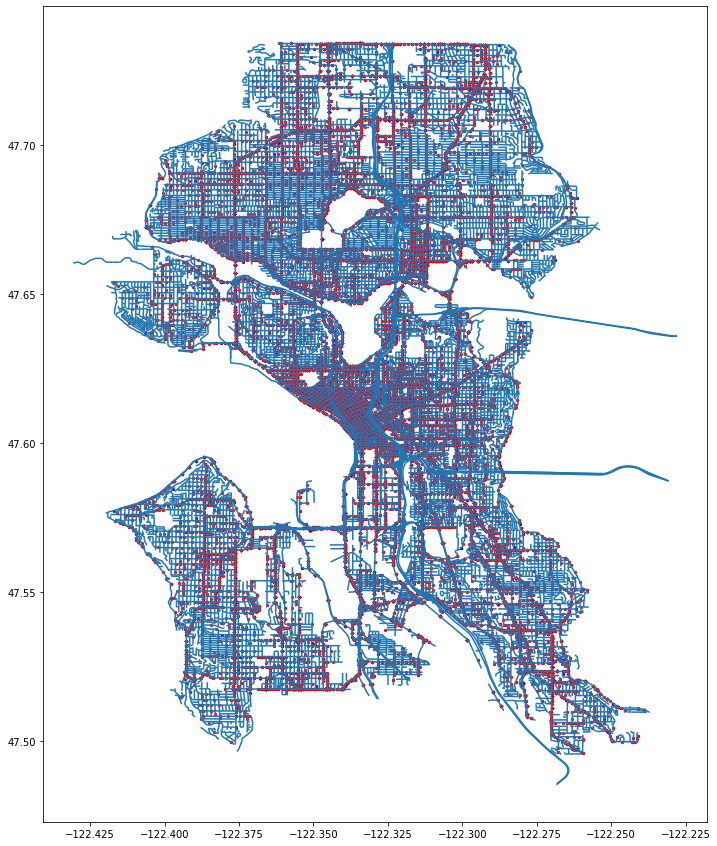

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
steet_map.plot(ax = ax)
geo_df[geo_df['SEVERITYDESC'] == 'Serious Injury Collision'].plot(ax = ax, markersize = 5, color = 'blue', marker = 'o')
geo_df[geo_df['SEVERITYDESC'] == 'Injury Collision'].plot(ax = ax, markersize = 5, color = 'red', marker = 'o')
#geo_df[geo_df['SEVERITYDESC'] == 'Property Damage Only Collision'].plot(ax = ax, markersize = 5, color = 'green', marker = 'o')
geo_df[geo_df['SEVERITYDESC'] == 'Fatality Collision'].plot(ax = ax, markersize = 5, color = 'purple', marker = 'o')

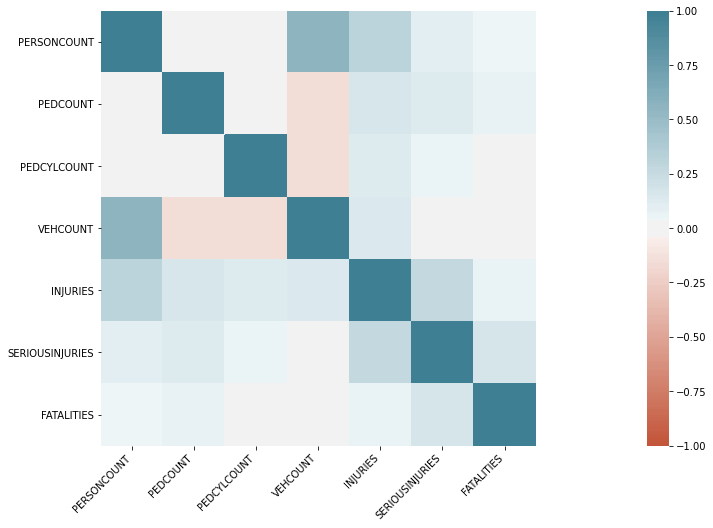

In [ ]:
# correlation matrix
corr = collision[['SEVERITYCODE', 'SEVERITYDESC','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INJURIES', 'SERIOUSINJURIES', 'FATALITIES','INCDATE', 'INCDTTM','INATTENTIONIND', 'UNDERINFL','SPEEDING','HITPARKEDCAR']].corr()
plt.figure(figsize=(40,8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);